In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

I'm using my macbook for all of this, but it should be fairly straightforward to adapt to the other resolutions.

# Cropping

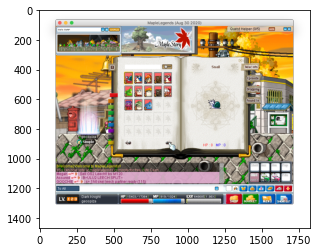

In [2]:
from pathlib import Path

screenshots = list(Path("../data/raw/main").glob("*"))
img = mpimg.imread(screenshots[0])
imgplot = plt.imshow(img)

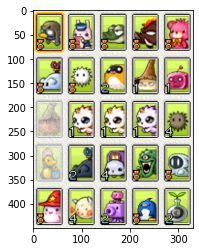

(450, 330, 4)

In [3]:
def imread(path):
    return mpimg.imread(path)

def imshow(img):
    plt.imshow(img, cmap=plt.get_cmap("gray"))
    plt.show()

def imsave(path, img):
    mpimg.imsave(path, img)

def crop(img):
    # TODO: this is all mac logic, needs to be redone for windows
    # but this is also going to be reimplemented in javascript
    # for visualization sake
    cropped = img[412:862,569:899]
    assert cropped.shape[:2] == (450, 330), cropped.shape
    return cropped

img = crop(imread(screenshots[4]))
imshow(img)
img.shape

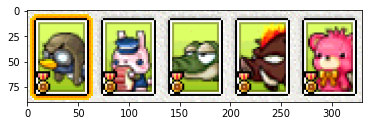

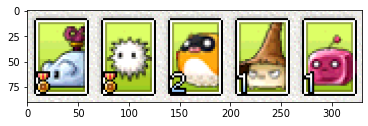

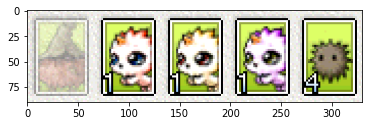

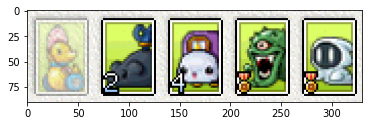

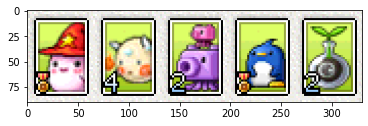

In [4]:
num_rows = 5
num_cols = 5

for i in range(num_rows):
    h = int(img.shape[0]/num_rows)
    row = img[i*h:(i+1)*h,]
    imshow(row)

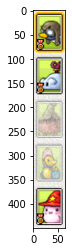

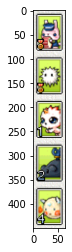

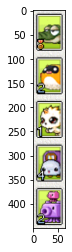

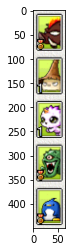

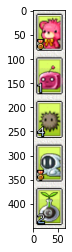

In [5]:
for i in range(num_cols):
    w = int(img.shape[1]/num_cols)
    row = img[:,i*w:(i+1)*w]
    imshow(row)

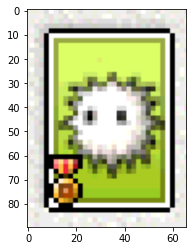

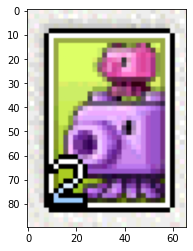

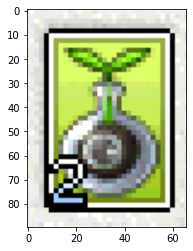

In [6]:
def crop_cards(img):
    num_rows = 5
    num_cols = 5
    cards = []
    h = int(img.shape[0]/num_rows)
    w = int(img.shape[1]/num_cols)
    for i in range(num_rows):
        for j in range(num_cols):
            card = img[i*h:(i+1)*h,j*w:(j+1)*w]
            cards.append(card)
    return cards

cards = crop_cards(img)
        
import random
for card in random.sample(cards, 3):
    imshow(card)

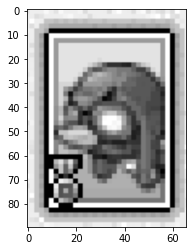

In [7]:
# https://stackoverflow.com/a/12201744
def rgb2gray(rgb):
    return (np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])*255).astype(int)

imshow(rgb2gray(cards[0]))

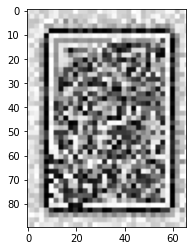

In [8]:
from functools import reduce
imshow(reduce(np.bitwise_xor, map(rgb2gray, cards)))

The cards are aligned correctly since xor'ing all the values retains the card shape.

# Reference

In [9]:
def generate_labels():
    # assign each one a label
    tab_counts = [
        ("red", 1),
        ("orange", 3),
        ("lightgreen", 4),
        ("green", 3),
        ("lightblue", 3),
        ("blue", 2),
        ("purple", 2),
        ("black", 2),
        ("gold", 2)
    ]
    labels = []
    for color, count in tab_counts:
        labels += [f"{color}_{i}" for i in range(count)]
    return labels

labels = generate_labels()
labels[:5]

['red_0', 'orange_0', 'orange_1', 'orange_2', 'lightgreen_0']

In [10]:
source = list(Path("../data/raw/reference").glob("*"))
assert len(labels) == len(source)
output = Path("../data/processed/reference")
output.mkdir(parents=True, exist_ok=True)

for i, label, path in zip(range(len(labels)), labels, source):
    img = imread(path)
    cropped = crop(img)
    name = f"{i:02}_{label}.png"
    imsave(output / name, cropped)

# Matching against reference

In [11]:
references = [
    (path.name, rgb2gray(imread(path)))
    for path in Path("../data/processed/reference").glob("*")
]

In [12]:
screenshots = [
    rgb2gray(crop(imread(path)))
    for path in list(Path("../data/raw/main").glob("*"))
]

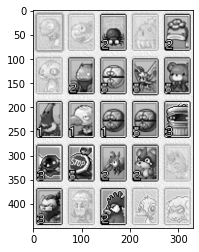

In [13]:
test = screenshots[2]
imshow(test)

In [14]:
from scipy.signal import convolve2d

def edge_filter(img):
    kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])
    x = convolve2d(img, kernel)
    x[x < 0] = 0
    x[x > 0] = 255
    return x

# might need some smoothing
def sobel_filter(img):
    kernel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
    kernel_y = kernel_x.T
    x = convolve2d(img, kernel_x) + convolve2d(img, kernel_y)
    x[x < 0] = 0
    x[x > 0] = 255
    return x

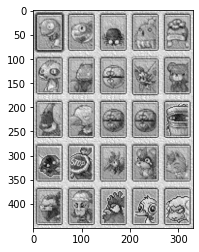

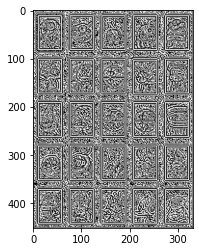

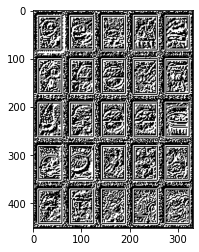

In [15]:
def test_filtering(test):
    imshow(test)
    imshow(edge_filter(test))
    imshow(sobel_filter(test))

test_filtering(references[2][1])

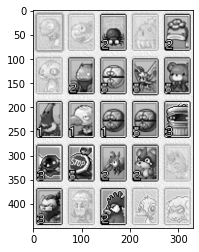

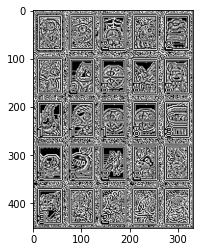

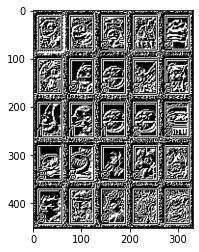

In [16]:
test_filtering(test)

In [17]:
def mse(a, b):
    """Mean Squared Error."""
    return ((a - b) ** 2).mean()

def match(img, refs):
    """Return the index into to a list of reference images
    of the closest match."""
    diffs = []
    for ref in refs:
        diff = round(mse(sobel_filter(img), sobel_filter(ref)))
        diffs.append(diff)
    index = diffs.index(min(diffs))
    return index, diffs
    
match(screenshots[2], [ref for _, ref in references])

(2,
 [18377,
  14136,
  4499,
  22289,
  14149,
  14474,
  14383,
  19873,
  14367,
  14668,
  16526,
  14599,
  15081,
  22183,
  14947,
  21090,
  14674,
  20114,
  15030,
  20840,
  14301,
  14659])

In [18]:
# test that it matches correctly
refs = [ref for _, ref in references]
diffs = []
for i, img in enumerate(screenshots):
    res, diff = match(img, refs)
    assert res == i, (i, res)
    diffs.append(diff)

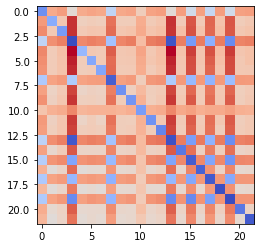

In [19]:
plt.imshow(np.array(diffs), cmap="coolwarm")
# there are a few that look suspiciously close

In [20]:
np.array(diffs)[:3]

array([[ 3756, 16462, 17334, 12252, 16423, 16889, 16616,  9479, 16635,
        16882, 13769, 16960, 17244, 12161, 17197, 10722, 17019,  9869,
        17212, 10772, 17072, 17271],
       [17505,  5583, 14325, 22244, 13582, 13855, 13685, 19657, 13850,
        13839, 16319, 14017, 14607, 22227, 13938, 20933, 14004, 20133,
        14649, 20884, 13807, 14296],
       [18377, 14136,  4499, 22289, 14149, 14474, 14383, 19873, 14367,
        14668, 16526, 14599, 15081, 22183, 14947, 21090, 14674, 20114,
        15030, 20840, 14301, 14659]])

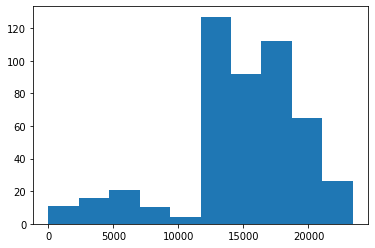

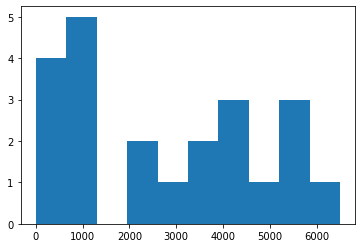

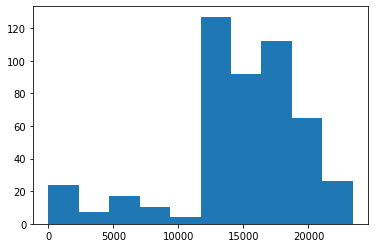

In [21]:
plt.hist(np.array(sum(diffs, [])))
plt.show()
# only the matches
plt.hist(np.diag(np.array(diffs)))
plt.show()
# except the matchs
plt.hist((np.array(diffs) - np.diag(np.diag(np.array(diffs)))).reshape(-1))
plt.show()

# Cards with monsters

In [22]:
screenshots = [
    rgb2gray(crop(imread(path)))
    for path in list(Path("../data/raw/main").glob("*"))
]

In [23]:
all_cards = []
for img in screenshots:
    all_cards += crop_cards(img)

len(all_cards)

550

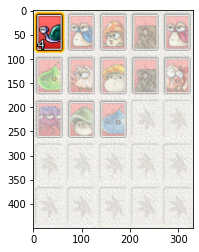

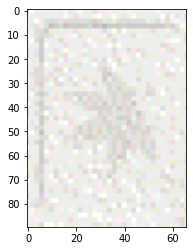

In [24]:
first = imread(sorted(Path("../data/processed/reference").glob("*"))[0])
imshow(first)
first_page = crop_cards(first)
empty_card = first_page[-1]
imshow(empty_card)

In [25]:
output = Path("../data/processed/empty")
output.mkdir(parents=True, exist_ok=True)
imsave(output / "empty.png", empty_card)

[1592, 1548, 1870, 1604, 1318, 1320, 1132, 1928, 1473, 1856, 1257, 1392, 118, 107, 128, 123, 129, 121, 119, 135, 108, 109, 95, 0]


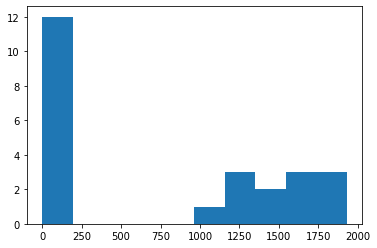

In [26]:
empty_card = rgb2gray(imread("../data/processed/empty/empty.png"))
diffs = [round(mse(rgb2gray(card), empty_card)) for card in first_page[1:]]
print(diffs)
plt.hist(diffs)
plt.show()

# Cards that have been seen

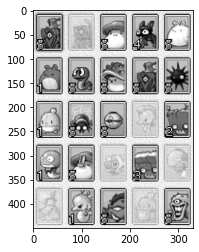

[15792, 1724, 9934, 15514, 8278, 10623, 12644, 11691, 15397, 15562, 8779, 11798, 10198, 1125, 13625, 10002, 10263, 1133, 12653, 1182, 1053, 9549, 13591, 1102, 11971]


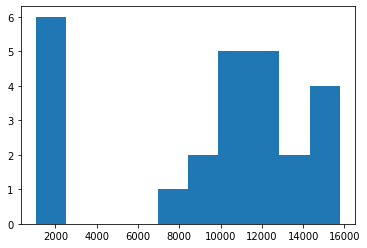

In [27]:
imshow(screenshots[1])
diffs = [
    round(mse(card, empty_card)) 
     for card in crop_cards(screenshots[1])
]
print(diffs)
plt.hist(diffs)
plt.show()

In [28]:
def filter_cards(cards, empty, threshold=500):
    return [
        card for card in cards
        if mse(card, empty) > threshold
    ]

len(filter_cards(map(rgb2gray, first_page), empty_card))

13

# How many cards per page?

In [29]:
res = []
for ref in refs:
    res.append(len(filter_cards(crop_cards(ref), empty_card)))
res, sum(res)

([13,
  25,
  25,
  1,
  25,
  25,
  25,
  10,
  25,
  25,
  20,
  25,
  25,
  1,
  25,
  6,
  25,
  8,
  25,
  5,
  25,
  25],
 414)

# Getting the tags for cards

Lets do some clustering, cause it's easier to programmatically query for images I want.

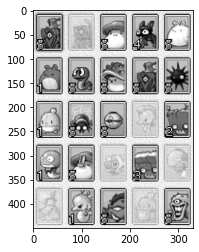

In [30]:
imshow(screenshots[1])

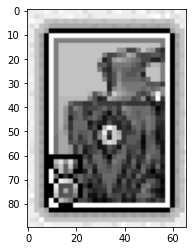

In [31]:
cards = crop_cards(screenshots[1])
imshow(cards[0])

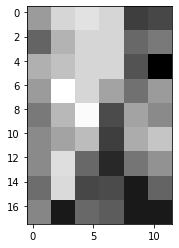

(18, 12)

In [32]:
def crop_tag(card):
    cropped = card[62:80, 11:23]
    assert cropped.shape[:2] == (18, 12), cropped.shape
    return cropped

imshow(crop_tag(cards[1]))
crop_tag(cards[1]).shape

In [33]:
references[0][1]

array([[226, 237, 237, ..., 236, 236, 237],
       [226, 237, 237, ..., 236, 236, 237],
       [237, 236, 236, ..., 226, 226, 237],
       ...,
       [236, 237, 237, ..., 219, 219, 237],
       [237, 254, 254, ..., 220, 220, 236],
       [237, 254, 254, ..., 220, 220, 236]])

In [34]:
empty_card = crop_cards(references[0][1])[-1]
def collect_tags(images):
    tags = []
    for img in images:
        cards = filter_cards(crop_cards(img), empty_card, 4000)
        for card in cards:
            tags.append(crop_tag(card))
    return tags

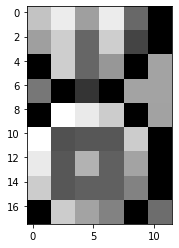

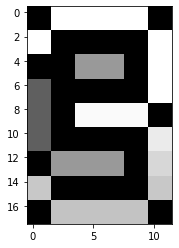

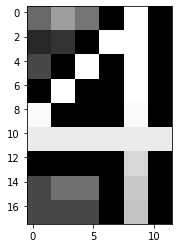

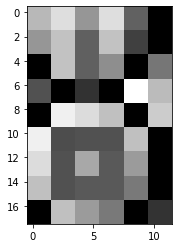

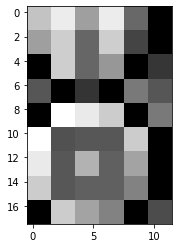

In [35]:
tags = collect_tags(screenshots)
for img in random.sample(tags, 5):
    imshow(img)

## Try clustering

In [36]:
np.array(tags).shape

(224, 18, 12)

In [37]:
X = np.array(tags).reshape(len(tags), -1)

In [38]:
from scipy import linalg

U, s, Vh = linalg.svd(X)
U.shape

(224, 224)

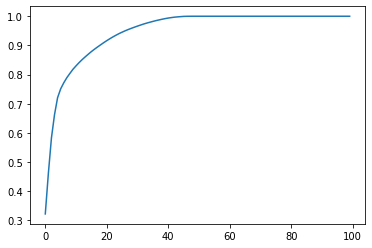

In [39]:
plt.plot(np.cumsum(s/sum(s))[:100])
plt.show()

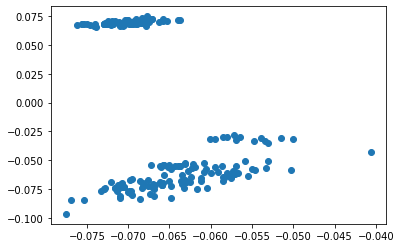

In [40]:
plt.scatter(U[:,0], U[:,1])
plt.show()

In [41]:
U[:,:32].shape

(224, 32)

In [42]:
from scipy.cluster.vq import kmeans2

feat = U[:, :32]
centroids, labels = kmeans2(feat, 5, iter=20, minit="++")
centroids.shape, labels.shape

((5, 32), (224,))

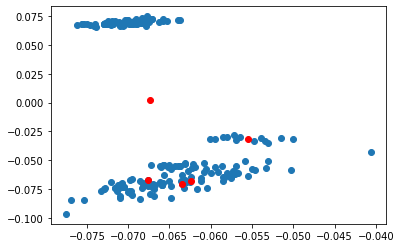

In [43]:
plt.scatter(feat[:,0], feat[:,1])
plt.scatter(centroids[:, 0], centroids[:, 1], c="red")
plt.show()

In [44]:
from collections import Counter
Counter(labels)

Counter({2: 202, 0: 12, 4: 8, 3: 1, 1: 1})

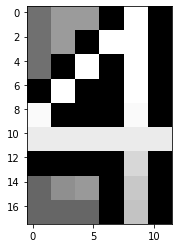

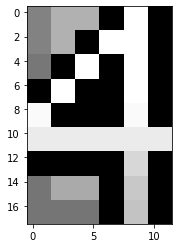

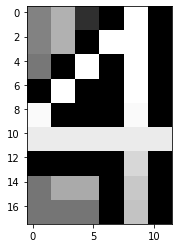

In [45]:
show = 3
for label, tag in zip(labels, tags):
    if label == 0 and show > 0:
        imshow(tag)
        show -= 1

Overall, the results are trash. None of the categories make any consistent sense. If I'm going to go this route, I need an actual classifier, but I don't have labels.

## Manual tagging

Luckily I only need to seed this once.

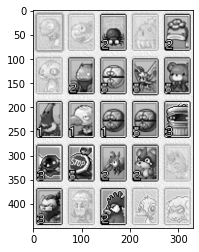

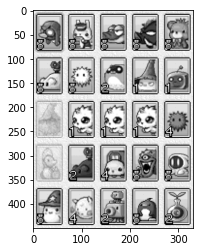

In [46]:
imshow(screenshots[2])
imshow(screenshots[4])

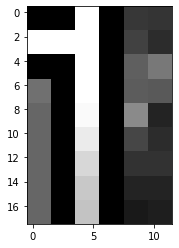

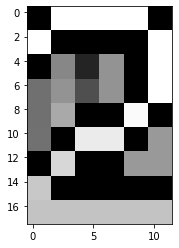

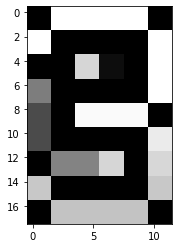

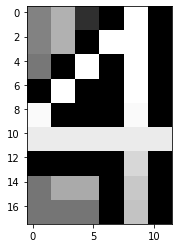

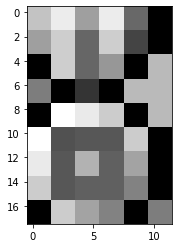

In [47]:
# 2-10 1
# 2-2 2
# 2-14 3
# 4-17 4
# 4-0 5

s2 = crop_cards(screenshots[2])
s4 = crop_cards(screenshots[4])

seed_tags = [
    crop_tag(s2[10]),
    crop_tag(s2[2]),
    crop_tag(s2[14]),
    crop_tag(s4[17]),
    crop_tag(s4[0]),
]
for tag in seed_tags:
    imshow(tag)

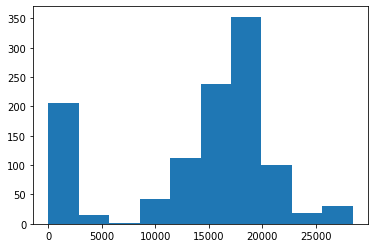

In [48]:
d = {}
diffs = []
for tag in tags:
    diff = [mse(tag, seed) for seed in seed_tags]
    diffs += diff
    index = diff.index(min(diff)) + 1
    d[index] = d.get(index, []) + [tag]
plt.hist(diffs)
plt.show()

In [49]:
for i in sorted(d.keys()):
    print(f"{i}: {len(d[i])}")

1: 54
2: 37
3: 18
4: 13
5: 102


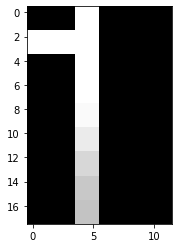

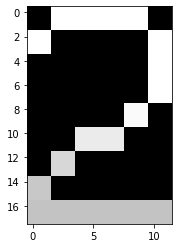

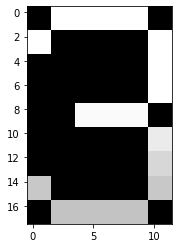

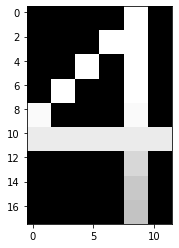

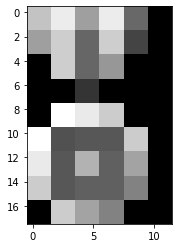

In [50]:
res = []
for i in sorted(d.keys()):
    res.append(reduce(np.bitwise_and, d[i]))
processed_tags = res

for tag in processed_tags:
    imshow(tag)

In [51]:
output = Path("../data/processed/seed_tags")
output.mkdir(parents=True, exist_ok=True)

for i, tag in enumerate(processed_tags):
    imsave(output / f"{i+1}.png", tag)

# Tagging monsters

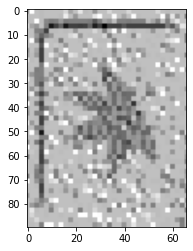

414


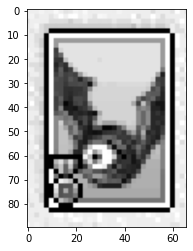

In [52]:
def collect_cards(screenshots, empty_card):
    cards = []
    for img in screenshots:
        cards += filter_cards(crop_cards(img), empty_card)
    return cards

screenshots = [
    rgb2gray(crop(imread(path)))
    for path in list(Path("../data/raw/main").glob("*"))
]
empty_card = rgb2gray(imread("../data/processed/empty/empty.png"))
imshow(empty_card)
cards = collect_cards(screenshots, empty_card)
print(len(cards))
imshow(cards[111])

In [53]:
entries = Path("../data/raw/entries.txt").read_text().split("\n")

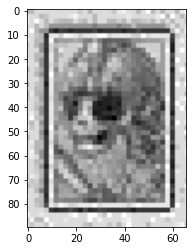

Officer Skeleton


In [54]:
imshow(cards[222])
print(entries[222])

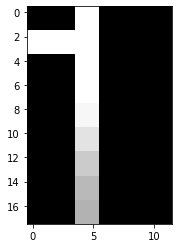

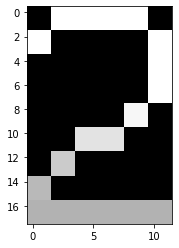

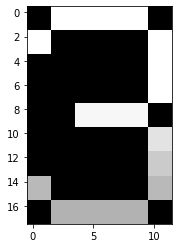

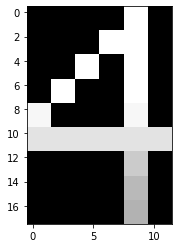

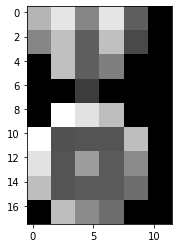

In [55]:
tags = [rgb2gray(imread(path)) 
        for path in Path("../data/processed/seed_tags").glob("*")]
for tag in tags:
    imshow(tag)

In [56]:
data = []
for entry, card in zip(entries, cards):
    datum = {"name": entry}
    if mse(card, empty_card) < 4000:
        datum["count"] = 0
    else:
        tag = crop_tag(card)
        # find a match
        diff = [mse(tag, seed) for seed in tags]
        datum["count"] = diff.index(min(diff)) + 1
    data.append(datum)

In [57]:
data

[{'name': 'Snail', 'count': 5},
 {'name': 'Blue Snail', 'count': 5},
 {'name': 'Shroom', 'count': 2},
 {'name': 'Stump', 'count': 5},
 {'name': 'Red Snail', 'count': 5},
 {'name': 'Slime', 'count': 5},
 {'name': 'Pig', 'count': 5},
 {'name': 'Orange Mushroom', 'count': 5},
 {'name': 'Dark Stump', 'count': 5},
 {'name': 'Ribbon Pig', 'count': 5},
 {'name': 'Octopus', 'count': 5},
 {'name': 'Green Mushroom', 'count': 5},
 {'name': 'Bubbling', 'count': 5},
 {'name': 'Axe Stump', 'count': 5},
 {'name': 'Ghost Stump', 'count': 0},
 {'name': 'Blue Mushroom', 'count': 5},
 {'name': 'Stirge', 'count': 4},
 {'name': 'Desert Rabbit (F)', 'count': 5},
 {'name': 'Desert Rabbit (M)', 'count': 1},
 {'name': 'Jr. Necki', 'count': 5},
 {'name': 'Horny Mushroom', 'count': 5},
 {'name': 'Dark Axe Stump', 'count': 5},
 {'name': 'Pinboom', 'count': 5},
 {'name': 'Jr. Cactus', 'count': 1},
 {'name': 'Trixter', 'count': 5},
 {'name': 'Jr. Sentinel', 'count': 5},
 {'name': 'Seacle', 'count': 0},
 {'name': 'W

In [58]:
sum([r["count"] for r in data])

744